In [1]:
from keras.models import Sequential
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dropout
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
import joblib
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
group = 'Oh'
J = '4'
dir = '../ml_cr/TrainingData_{}_{}/'.format(group, J)
data = dir + 'generated_data_{}.csv'
targets = dir + 'generated_targets_{}.csv'
x = np.array(pd.read_csv(data.format(50000), header=None))
y = np.array(pd.read_csv(targets.format(50000), header=None))

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_val = x_test[:2000]
x_test = x_test[2000:]
y_val = y_test[:2000]
y_test = y_test[2000:]

In [5]:
# center the image data for each channel (mean of zero)
x_mean = np.mean(x_train, axis=(0,1), keepdims=True)
x_train -= x_mean
x_val -= x_mean
x_test -= x_mean

In [5]:
x_mean = np.load(dir + 'x_mean_{}_{}_FF.npy'.format(group, J))

In [8]:
# normalize each of the targets (mean of zero and std of one)
# y_mean = np.mean(y_train, axis=(0,), keepdims=True)
# y_train -= y_mean
# y_val -= y_mean
# y_test -= y_mean
# y_std = np.std(y_train, axis=(0,), keepdims=True)
# y_train /= y_std
# y_val /= y_std
# y_test /= y_std

In [6]:
model = Sequential()

model.add(layers.Dense(2048, activation='relu', input_shape=(384,)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              788480    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)             

In [7]:
from keras.models import load_model
model = load_model(dir + '{}_{}_FF_model.h5'.format(group, J))

Train on 40000 samples, validate on 2000 samples
Epoch 1/50
40000/40000 [==============================] - 10s 239us/step - loss: 287.7849 - mae: 12.2418 - val_loss: 292.6641 - val_mae: 11.2664
Epoch 2/50
40000/40000 [==============================] - 6s 155us/step - loss: 84.7669 - mae: 6.0820 - val_loss: 21.8552 - val_mae: 2.7837
Epoch 3/50
40000/40000 [==============================] - 6s 148us/step - loss: 10.4223 - mae: 2.0168 - val_loss: 53.5254 - val_mae: 4.3845
Epoch 4/50
40000/40000 [==============================] - 6s 148us/step - loss: 8.8294 - mae: 1.8115 - val_loss: 65.8909 - val_mae: 4.7753
Epoch 5/50
40000/40000 [==============================] - 6s 147us/step - loss: 8.0745 - mae: 1.7076 - val_loss: 47.9532 - val_mae: 4.1667
Epoch 6/50
40000/40000 [==============================] - 6s 149us/step - loss: 7.6242 - mae: 1.6278 - val_loss: 49.1467 - val_mae: 3.9221
Epoch 7/50
40000/40000 [==============================] - 6s 151us/step - loss: 6.8538 - mae: 1.5282 - val_lo

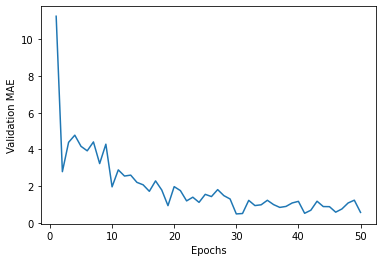

In [10]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(x_train,
    y_train,
    epochs=50,
    batch_size=512,
    validation_data=(x_val, y_val))

average_mae_history = history.history['val_mae']
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [11]:
model.evaluate(x_test, y_test)

8000/8000 [==============================] - 1s 137us/step


[0.9283125929832459, 0.5441433191299438]

In [8]:
y_real = np.array(pd.read_csv(targets.format(1000), header=None))
example_x = np.array(pd.read_csv(data.format(1000), header=None))

In [9]:
from sklearn import metrics
example_x -= x_mean
y_pred = model.predict(example_x)
# y_pred = (y_pred * y_std) + y_mean

In [10]:
print('Mean absolute error: {}'.format(metrics.mean_absolute_error(y_real[:,0], y_pred[:,0])))
print('Mean squared error: {}'.format(metrics.mean_squared_error(y_real[:,0], y_pred[:,0])))
print('Explained varience score: {}'.format(metrics.explained_variance_score(y_real[:,0], y_pred[:,0])))
print('r^2 score: {}'.format(metrics.r2_score(y_real[:,0], y_pred[:,0])))

Mean absolute error: 0.38815058690919996
Mean squared error: 0.34657296519373704
Explained varience score: 0.9982848261052861
r^2 score: 0.9982622106402045


In [11]:
print('Mean absolute error: {}'.format(metrics.mean_absolute_error(y_real[:,1], y_pred[:,1])))
print('Mean squared error: {}'.format(metrics.mean_squared_error(y_real[:,1], y_pred[:,1])))
print('Explained varience score: {}'.format(metrics.explained_variance_score(y_real[:,1], y_pred[:,1])))
print('r^2 score: {}'.format(metrics.r2_score(y_real[:,1], y_pred[:,1])))

Mean absolute error: 0.10311309057523951
Mean squared error: 0.01695130731645124
Explained varience score: 0.9668246396384261
r^2 score: 0.9470339301263889


Text(0.5, 0, 'Absolute error')

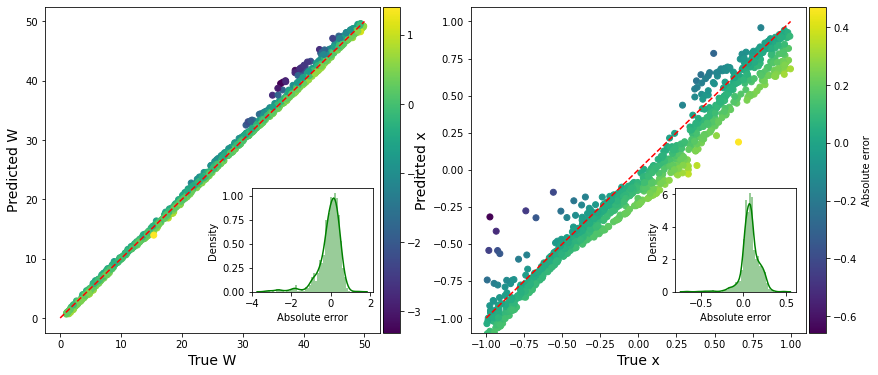

In [12]:
data = pd.DataFrame()

data['pred1'] = np.array(y_pred[:,0])
data['real1'] = pd.DataFrame(y_real).reset_index(drop=True)[0]
data['error1'] = data['pred1']- data['real1']

data2 = pd.DataFrame()
data2['pred2'] = np.array(y_pred[:,1])
data2['real2'] = pd.DataFrame(y_real).reset_index(drop=True)[1]
data2['error2'] = data2['pred2']- data2['real2']

data2.to_csv('ffdata2.csv', header=None, index=None)
data.to_csv('ffdata.csv', header=None, index=None)


def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
ax2 = plt.axes([0.33, 0.22, 0.12, 0.24])
ax3 = plt.axes([0.75, 0.22, 0.12, 0.24])
# fig.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=None, hspace=None)
error0 = y_real[:,0]-y_pred[:,0]
error1 = y_real[:,1]-y_pred[:,1]
# df['Target'] = df['Target'].astype('category')

p1 = ax[0].scatter(y_real[:,0], y_pred[:,0], c=error0)
cb = colorbar(p1)
# cb.ax.set_ylabel('Absolute error')

ax[0].set_xlabel('True W', fontsize=14)
ax[0].set_ylabel('Predicted W', fontsize=14)
# legend1 = ax[0].legend(*p1.legend_elements(num=5), loc='upper left', title='Absolute error')
ax[0].plot([0, 50], [0, 50], c='r', ls='--')


p2 = ax[1].scatter(y_real[:,1], y_pred[:,1], c=error1)
cb2 = colorbar(p2)
cb2.ax.set_ylabel('Absolute error')
# legend2 = ax[1].legend(*p2.legend_elements(num=6), loc='upper left', title='Absolute error')
ax[1].set_xlabel('True x', fontsize=14)
ax[1].set_ylabel('Predicted x', fontsize=14)
ax[1].set_ylim(-1.1, 1.1)
ax[1].plot([-1, 1], [-1, 1], c='r', ls='--')


sns.distplot(error0, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')
sns.distplot(error1, color="g", kde=True, ax=ax3, norm_hist=False)
ax3.set_ylabel('Density')
ax3.set_xlabel('Absolute error')